<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Copy_of_DPHI_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns




import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/hippocorpus/train_set_label.csv" )
test = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/hippocorpus/test_set_label.csv')

df.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,memType
0,39DD6S19JQXBBJGPFEBWSF4G1TQEZJ,1025,YGROBIBW,35.0,Man,white,one,3.0,2.0,3.0,4.094345,my friend's death and how our group of friends...,the mourning process had a kind of positive si...,0.375,3RKNTXVS3NKSI9BOEGJK201G4H2A46,NaN,NaN,NaN,We were friends from high school. I got a call...,3.0,my friend's death. Old friends reunited to sha...,60.0,retold
1,3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87,1987,KK89LEHY,35.0,woman,indian,one,5.0,3.0,5.0,5.010635,the loss of my father and the impact he had on...,he died very suddenly and within minutes,0.625,NaN,3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87,NaN,NaN,"Five months ago, my father passed away from a ...",2.0,"My dad, who was a significant person in my lif...",150.0,recalled
2,3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S,1604,JIWFAU5T,35.0,man,White,one,one,5.0,5.0,4.787492,how I met my wife.,when I got my unreserved kind of love.,1.000,NaN,3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S,NaN,NaN,My Most Memorable Day of My Life! I found my o...,1.0,The best thing may be difficult to find. I was...,120.0,recalled
3,3Q8GYXHFEQOY77CMCZYLDNXJ2YBC58,6369,1NHCDDOJ,40.0,woman,white,one,one,NaN,4.0,5.480639,the events leading up to my wedding,a surprise flash mob wedding proposal,0.875,NaN,3WLEIWSYHP3XPI4FG8AOQ7RM04VH26,1.0,"This was not at all how I got engaged, but a w...",It has been such a whirlwind these past 8 mont...,1.0,The event described details my wedding which o...,240.0,imagined
4,32AT8R96GMVVZ3RXAMWT04TG9CISU0,1083,A5SWJWSQ,30.0,MAN,white,one,5.0,3.0,5.0,4.094345,Attending a funeral for my cousin.,How emotional I felt during at the cemetery.,1.000,NaN,32AT8R96GMVVZ3RXAMWT04TG9CISU0,NaN,NaN,Today was one of the saddest days of my life. ...,4.0,My cousin recently passed away due to brain ca...,60.0,recalled


In [5]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

for col in ['recAgnPairId','recImgPairId','WorkerId']:
  
  mode = df[col].mode()[0]

  df[col].fillna(mode,inplace=True)
  test[col].fillna(mode,inplace=True)

  df[col] = lb.fit_transform(df[col])

  mapper = dict(zip(lb.classes_,lb.transform(lb.classes_)))
  test[col] = test[col].map(mapper)

  test[col].fillna(-1,inplace=True)
  
  df[col] = df[col].astype('float')
  test[col] = test[col].astype('float')

In [6]:
five_likert_points = ['distracted','draining','frequency','importance','similarity','stressful']

df[five_likert_points]

,distracted,draining,frequency,importance,similarity,stressful
0,one,3.0,2.0,3.0,NaN,3.0
1,one,5.0,3.0,5.0,NaN,2.0
2,one,one,5.0,5.0,NaN,1.0
3,one,one,NaN,4.0,1.0,1.0
4,one,5.0,3.0,5.0,NaN,4.0
...,...,...,...,...,...,...
6792,one,3.0,3.0,5.0,NaN,5.0
6793,one,2.0,3.0,5.0,NaN,3.0
6794,one,2.0,NaN,4.0,4.0,1.0
6795,one,5.0,NaN,5.0,5.0,3.0


In [7]:
df['distracted'] = np.where(df['distracted'] == 'one',1.0,df['distracted'])
df['distracted'] = df['distracted'].astype(float)

df['draining'] = np.where(df['draining'] == 'one',1.0,df['draining'])
df['draining'] = df['draining'].astype(float)

In [8]:
test['distracted'] = np.where(test['distracted'] == 'one',1.0,test['distracted'])
test['distracted'] = test['distracted'].astype(float)

test['draining'] = np.where(test['draining'] == 'one',1.0,test['draining'])
test['draining'] = test['draining'].astype(float)

In [9]:
for col in five_likert_points:
  
  mode = df[col].mode()[0]
  df[col].fillna(mode,inplace=True)
  test[col].fillna(mode,inplace=True)


df[five_likert_points].isnull().sum()

distracted    0
draining      0
frequency     0
importance    0
similarity    0
stressful     0
dtype: int64

In [10]:
df['memType'].value_counts()

recalled    2760
imagined    2745
retold      1292
Name: memType, dtype: int64

In [11]:
target_mapper = {'recalled':0,
                 'imagined':1,
                 'retold':2}

df['memType'] = df['memType'].map(target_mapper)

In [12]:
df.corr().loc['memType',:]

WorkTimeInSeconds    0.085427
WorkerId            -0.010686
annotatorAge         0.038015
distracted          -0.118669
draining            -0.083118
frequency           -0.168703
importance          -0.169015
logTimeSinceEvent   -0.208512
openness             0.050327
recAgnPairId         0.195039
recImgPairId         0.213688
similarity           0.172066
stressful           -0.094833
timeSinceEvent      -0.047780
memType              1.000000
Name: memType, dtype: float64

In [13]:
pip install catboost

     |████████████████████████████████| 65.8MB 66kB/s 


In [14]:
df['annotatorGender'] = df['annotatorGender'].apply(lambda x:str(x).lower())


def handle_gender(value):
  if value not in ['woman','man','nonbinary','transman']:
    return 'OTHERS'
  else:
    return value

df['annotatorGender'] =  df['annotatorGender'].apply(handle_gender)
df['annotatorGender'].value_counts()

woman        3417
man          3314
OTHERS         35
nonbinary      19
transman       12
Name: annotatorGender, dtype: int64

In [15]:
df['annotatorRace'] = df['annotatorRace'].apply(lambda x:str(x).lower())

def handle_race(value):
  if value not in ['white','black','hisp','asian']:
    return 'OTHERS'

  else:
    return value

df['annotatorRace'] = df['annotatorRace'].apply(handle_race)

In [16]:
test['annotatorGender'] = test['annotatorGender'].apply(lambda x:str(x).lower())
test['annotatorGender'] =  test['annotatorGender'].apply(handle_gender)


test['annotatorRace'] = test['annotatorRace'].apply(lambda x:str(x).lower())
test['annotatorRace'] = test['annotatorRace'].apply(handle_race)

In [17]:
for col in ['annotatorGender','annotatorRace']:
  df[col] = lb.fit_transform(df[col])

  mapper = dict(zip(lb.classes_,lb.transform(lb.classes_)))
  test[col] = test[col].map(mapper)
  

In [18]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,log_loss
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,ComplementNB
import warnings
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [19]:
df.corr().columns

Index(['WorkTimeInSeconds', 'WorkerId', 'annotatorAge', 'annotatorGender',
       'annotatorRace', 'distracted', 'draining', 'frequency', 'importance',
       'logTimeSinceEvent', 'openness', 'recAgnPairId', 'recImgPairId',
       'similarity', 'stressful', 'timeSinceEvent', 'memType'],
      dtype='object')

In [20]:
list_of_cols = [col for col in df.columns if col!='memType']

highly_corr = []

for i in range(len(list_of_cols)):
  if list_of_cols[i] not in df.corr().columns:
    continue
  
  for j in range(i+1,len(list_of_cols)):
    if list_of_cols[j] not in df.corr().columns:
      continue
    
    if df.corr().loc[list_of_cols[i],list_of_cols[j]] > 0.6:
      highly_corr.append((list_of_cols[i],list_of_cols[j]))

In [21]:
highly_corr

[('draining', 'stressful')]

In [22]:
df.corr().loc['memType',:]

WorkTimeInSeconds    0.085427
WorkerId            -0.010686
annotatorAge         0.038015
annotatorGender     -0.010332
annotatorRace        0.010526
distracted          -0.118669
draining            -0.083118
frequency           -0.168703
importance          -0.169015
logTimeSinceEvent   -0.208512
openness             0.050327
recAgnPairId         0.195039
recImgPairId         0.213688
similarity           0.172066
stressful           -0.094833
timeSinceEvent      -0.047780
memType              1.000000
Name: memType, dtype: float64

In [23]:
df['combo_1'] = df['distracted'] * df['frequency']
df['combo_2'] = df['frequency'] * df['importance']
df['combo_3'] = df['importance'] * df['similarity']
df['combo_4'] = df['similarity'] * df['logTimeSinceEvent']

In [24]:
test['combo_1'] = test['distracted'] * test['frequency']
test['combo_2'] = test['frequency'] * test['importance']
test['combo_3'] = test['importance'] * test['similarity']
test['combo_4'] = test['similarity'] * test['logTimeSinceEvent']

In [25]:
df.columns

Index(['AssignmentId', 'WorkTimeInSeconds', 'WorkerId', 'annotatorAge',
       'annotatorGender', 'annotatorRace', 'distracted', 'draining',
       'frequency', 'importance', 'logTimeSinceEvent', 'mainEvent',
       'mostSurprising', 'openness', 'recAgnPairId', 'recImgPairId',
       'similarity', 'similarityReason', 'story', 'stressful', 'summary',
       'timeSinceEvent', 'memType', 'combo_1', 'combo_2', 'combo_3',
       'combo_4'],
      dtype='object')

In [26]:
selected = ['distracted','frequency','importance','similarity','recAgnPairId','recImgPairId',
            'combo_1', 'combo_2', 'combo_3',
       'combo_4','draining','stressful','openness']

X = df[selected]
y = df['memType']


print(X.shape,y.shape)

(6797, 13) (6797,)


In [27]:
X.dtypes

distracted      float64
frequency       float64
importance      float64
similarity      float64
recAgnPairId    float64
recImgPairId    float64
combo_1         float64
combo_2         float64
combo_3         float64
combo_4         float64
draining        float64
stressful       float64
openness        float64
dtype: object

In [28]:
X.isnull().sum()

distracted      0
frequency       0
importance      0
similarity      0
recAgnPairId    0
recImgPairId    0
combo_1         0
combo_2         0
combo_3         0
combo_4         0
draining        0
stressful       0
openness        0
dtype: int64

In [29]:
y.value_counts(normalize=True)

0    0.406061
1    0.403855
2    0.190084
Name: memType, dtype: float64

Running 1 iteration
0.9723530303935652
0.9720444979419978
Running 2 iteration
0.970579789084452
0.9661560107132038
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.9661560107132038 0.9723530303935652 0.9702833320333047


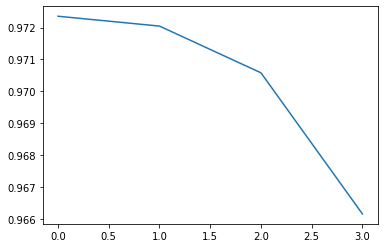

In [30]:
iterations = 2
scores = []
scores_val = []
target = y
temp = X
for i in range(iterations):
    print(f'Running {i+1} iteration')
    
    kfold = StratifiedKFold(n_splits = 2, shuffle=True)
    
    for train_index,test_index in kfold.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = lgb.LGBMClassifier(max_depth = 6, n_estimators=300,random_state=60,n_jobs=-1,class_weight='balanced')    

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds,average='weighted'))
        scores.append(f1_score(ytest,preds,average='weighted'))

        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

In [31]:
model = lgb.LGBMClassifier(max_depth = 6, n_estimators=300,random_state=60,n_jobs=-1)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=60, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [32]:
preds = model.predict(test[selected])

In [33]:
inv_mapper = {v: k for k, v in target_mapper.items()}

In [34]:
result = pd.DataFrame(preds,columns=['prediction'])

result['prediction'] = result['prediction'].map(inv_mapper)

result.head()

,prediction
0,imagined
1,retold
2,recalled
3,retold
4,imagined


In [35]:
result.value_counts(normalize=True)

prediction
recalled      0.404473
imagined      0.394750
retold        0.200778
dtype: float64

In [36]:
result.to_csv('dphi20_2.csv',index=False)